In [1]:
import pandas as pd
# Load the Sentiment140 dataset as a data frame
df = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding = 'latin1', names=['polarity', 'id', 'date', 'query', 'user', 'text'])
# Print the first 5 rows of the data frame
print(f"\n The shape data is:{df.shape}")


 The shape data is:(1600000, 6)


In [2]:
data = df.copy()
data = data.sample(frac=1)

In [3]:
from pandas.api.types import is_numeric_dtype, is_string_dtype

for col_name in data.columns:
    if is_numeric_dtype(data[col_name]):
        data[col_name] = data[col_name].fillna(0)
    elif is_string_dtype(data[col_name]):
        data[col_name] = data[col_name].fillna('')
data.head()

,polarity,id,date,query,user,text
1528565,4,2177405145,Mon Jun 15 06:02:54 PDT 2009,NO_QUERY,Jaffy_Lovecakes,has eat nearly a whole box of oreo's this week...
688429,0,2251523140,Sat Jun 20 03:46:46 PDT 2009,NO_QUERY,stevenperkins,"Dear Co-Operative Insurance: my name is, as th..."
242447,0,1981310059,Sun May 31 08:53:07 PDT 2009,NO_QUERY,holtong,@tomwilliamsboat I know so excited xxx
1183975,4,1982517510,Sun May 31 11:22:05 PDT 2009,NO_QUERY,agb57,&quot;Takin' Care of Business&quot; by Bachman...
382052,0,2052910655,Sat Jun 06 02:30:43 PDT 2009,NO_QUERY,MythosEngineer,@whoiscraig Feeling absolutly shattered and it...


In [4]:
def clean_text(x):
    from gensim.utils import simple_preprocess
    import contractions
    x = contractions.fix(x)
    x = ' '.join(simple_preprocess(x))
    return x

In [5]:
from tqdm import tqdm
tqdm.pandas()
data['clean_text'] = data['text'].progress_apply(clean_text)

100%|█████████████████████████████████████████████████████████████████████| 1600000/1600000 [00:36<00:00, 44068.30it/s]


In [7]:
data['polarity'] = data['polarity'].progress_apply((lambda x: 1 if x == 4 else 0))

100%|███████████████████████████████████████████████████████████████████| 1600000/1600000 [00:01<00:00, 1308776.77it/s]


In [8]:
data

,polarity,id,date,query,user,text,clean_text
1528565,1,2177405145,Mon Jun 15 06:02:54 PDT 2009,NO_QUERY,Jaffy_Lovecakes,has eat nearly a whole box of oreo's this week...,has eat nearly whole box of oreo this weekend ...
688429,0,2251523140,Sat Jun 20 03:46:46 PDT 2009,NO_QUERY,stevenperkins,"Dear Co-Operative Insurance: my name is, as th...",dear co operative insurance my name is as the ...
242447,0,1981310059,Sun May 31 08:53:07 PDT 2009,NO_QUERY,holtong,@tomwilliamsboat I know so excited xxx,tomwilliamsboat know so excited xxx
1183975,1,1982517510,Sun May 31 11:22:05 PDT 2009,NO_QUERY,agb57,&quot;Takin' Care of Business&quot; by Bachman...,quot takin care of business quot by bachman tu...
382052,0,2052910655,Sat Jun 06 02:30:43 PDT 2009,NO_QUERY,MythosEngineer,@whoiscraig Feeling absolutly shattered and it...,whoiscraig feeling absolutly shattered and its...
...,...,...,...,...,...,...,...
605155,0,2222163976,Thu Jun 18 06:35:25 PDT 2009,NO_QUERY,ilovegirlsaloud,@jackpercival Yeah ... I even rang them up to ...,jackpercival yeah even rang them up to see if ...
1550895,1,2183895448,Mon Jun 15 15:07:59 PDT 2009,NO_QUERY,ALChristopher,Hey girls...i'm running a few minutes late so ...,hey girls am running few minutes late so start...
420608,0,2062243704,Sat Jun 06 22:41:56 PDT 2009,NO_QUERY,focusgini,Washington was fantastic...sad that its over.,washington was fantastic sad that its over
756938,0,2289626312,Mon Jun 22 20:44:36 PDT 2009,NO_QUERY,prettyrach,@jenniferrooney I'msorry you had a bad day,jenniferrooney msorry you had bad day


In [9]:
%matplotlib inline
import gensim
import logging
import numpy as np, matplotlib.pyplot as plt, os
import pandas as pd
import json, zipfile
# configure logger. Can be logging.Info or logging.Error to control printouts during training
logging.basicConfig(format='%(asctime)s: %(levelname)s: %(message)s', level = logging.ERROR) 
root_notebook_folder = os.path.abspath('.')
data_folder = os.path.abspath('./local_data/twitter_airline_sentiment')
data_folder

'C:\\Users\\Leon\\Machine Learning\\Data science for finance\\local_data\\twitter_airline_sentiment'

In [10]:
def load_stopwords(data_folder):
    stopwords_file_name = os.path.join(data_folder, 'stopwords.txt')
    stopwords_url = "https://gist.githubusercontent.com/sebleier/554280/raw/7e0e4a1ce04c2bb7bd41089c9821dbcf6d0c786c/NLTK's%2520list%2520of%2520english%2520stopwords"

    if not os.path.isfile(stopwords_file_name):
        import requests
        stopwords = requests.get(stopwords_url).text.split()
        with open(stopwords_file_name,'w+t', encoding='utf-8') as out_file:
            out_file.write(' '.join(stopwords))
    else: 
        with open(stopwords_file_name,'rt', encoding='utf-8') as in_file:
            stopwords = in_file.readline().split()
    stopwords = set(stopwords)
    return stopwords
stopwords = load_stopwords(data_folder)
print(stopwords)

{'other', 'be', 'who', 'his', 'these', 'out', 'then', 't', 'yourselves', 'that', 'and', 'most', 'we', 'is', 'own', 'under', 'if', 'by', 'can', 'am', 'where', 'will', 'why', 'off', 'your', 'which', 'very', 'too', 'my', 'a', 'to', 'her', 'itself', 'how', 'were', 'being', 'no', 'are', 'having', 'with', 'i', 'themselves', 'our', 'myself', 'he', 'here', 'again', 'further', 'all', 'yourself', 'its', 'down', 'does', 'after', 'those', 'some', 'the', 'hers', 'herself', 'did', 'above', 'for', 'whom', 'should', 'into', 'you', 'they', 'from', 'on', 'or', 'she', 'ourselves', 'theirs', 'have', 'an', 'same', 'had', 'at', 'such', 'any', 'during', 'this', 'because', 'just', 'has', 'been', 'against', 's', 'few', 'now', 'there', 'him', 'himself', 'between', 'what', 'not', 'was', 'me', 'it', 'both', 'of', 'while', 'so', 'nor', 'but', 'until', 'once', 'than', 'do', 'ours', 'below', 'more', 'them', 'up', 'only', 'in', 'over', 'yours', 'through', 'doing', 'each', 'don', 'before', 'their', 'as', 'about', 'whe

In [11]:
def tokenize(x, stopwords):
    from gensim.utils import simple_preprocess
    return [ token for token in simple_preprocess(x['clean_text']) if token not in stopwords]
data['tokens'] = data.progress_apply(tokenize, stopwords=stopwords, axis=1)

100%|█████████████████████████████████████████████████████████████████████| 1600000/1600000 [00:39<00:00, 40814.34it/s]


# Split into train & test

In [12]:
import numpy as np

In [13]:
train_test_mask = np.random.random((len(data),))<0.8
train_data = data[train_test_mask].copy()
test_data = data[~train_test_mask].copy()
print(f"Train<->test data: {len(train_data)} <-> {len(test_data)}")

Train<->test data: 1280483 <-> 319517


In [14]:
import requests

In [15]:
stopwords_url = "https://gist.githubusercontent.com/sebleier/554280/raw/7e0e4a1ce04c2bb7bd41089c9821dbcf6d0c786c/NLTK's%2520list%2520of%2520english%2520stopwords"
stopwords = requests.get(stopwords_url).text.split()

### SVD-XG-boost

In [16]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD

svd_pipeline_hashtags = Pipeline([
    ('vect',CountVectorizer(stop_words=stopwords)),
    ('tfidf',TfidfTransformer()),
    ('norm',Normalizer(norm='l2')),
    ('svd', TruncatedSVD(n_components = 150))
    ])
svd_doc_vectors = svd_pipeline_hashtags.fit_transform(tqdm(train_data['clean_text']))

100%|████████████████████████████████████████████████████████████████████| 1280483/1280483 [00:10<00:00, 120785.90it/s]


In [17]:
print('Dictionary size: {}'.format(len(svd_pipeline_hashtags.named_steps['vect'].get_feature_names_out())))

Dictionary size: 525221


#### Train XGBoost model

In [19]:
!pip install xgboost

     ---------------------------------------- 89.1/89.1 MB 5.0 MB/s eta 0:00:00


In [20]:
from xgboost import XGBClassifier
svd_xgboost_model = XGBClassifier()
svd_xgboost_model.fit(X=svd_doc_vectors,y=train_data['polarity'])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

#### Make predictions with trained SVD and XGBoost

In [22]:
test_svd_xgboost_vectors = svd_pipeline_hashtags.transform(test_data['clean_text'])
test_svd_xgboost_predicted_classes = svd_xgboost_model.predict(test_svd_xgboost_vectors)

In [24]:
from sklearn.metrics import classification_report
print(classification_report(test_data['polarity'], test_svd_xgboost_predicted_classes))

              precision    recall  f1-score   support

           0       0.73      0.71      0.72    159580
           1       0.72      0.74      0.73    159937

    accuracy                           0.72    319517
   macro avg       0.73      0.72      0.72    319517
weighted avg       0.73      0.72      0.72    319517



In [26]:
from sklearn import metrics
from tqdm import tqdm

y_true = test_data['polarity']

# Get the predicted labels
y_pred = test_svd_xgboost_predicted_classes
# Calculate the accuracy
# accuracy = metrics.accuracy_score(y_true, y_pred)
# Calculate the precision
precision = metrics.precision_score(y_true, y_pred,pos_label=1)
# Calculate the recall
recall = metrics.recall_score(y_true, y_pred,pos_label=1)
# Calculate the F1 score
f1 = metrics.f1_score(y_true, y_pred,pos_label=1)
auc=metrics.roc_auc_score(y_true, y_pred)
cm = metrics.confusion_matrix(y_true,y_pred)

# Print the results
# print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 score:", f1)
print('AUC score:', auc)
print('Confusion Matrix', cm)

Precision: 0.7170204689109961
Recall: 0.7440179570705966
F1 score: 0.7302697793161009
AUC score: 0.7248633462505507
Confusion Matrix [[112617  46963]
 [ 40941 118996]]


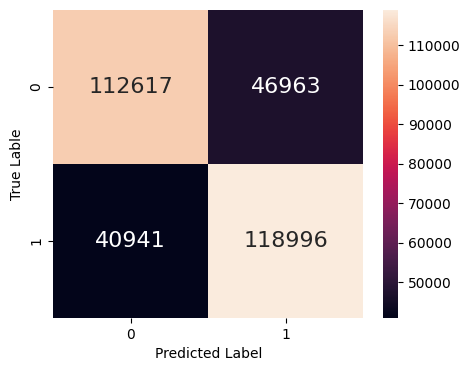

In [27]:
import matplotlib.pyplot as plt
import seaborn as sn
plt.figure(figsize=(5,4))
# cm_df = pd.DataFrame(cm, index = ['Negative','Positive'], columns = ['Negative','Positive'])
sn.heatmap(cm, annot=True, fmt='d', annot_kws={'size':16})
plt.xlabel("Predicted Label"); plt.ylabel('True Lable');

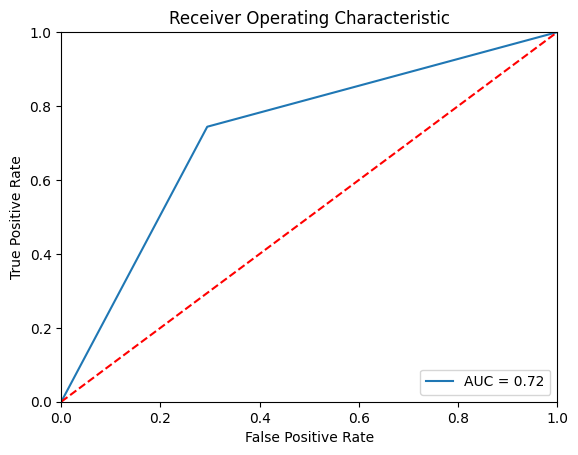

In [28]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Calculate FPR and TPR
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label='AUC = %0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.show()